# Behavioral Guided Single-Cell Transcriptomics Analysis (Part 3)
<span style="font-size:0.85em;">First Written by: Farid Keramati (12 Feb 2024) - Last Update: Farid Keramati (9 Mar 2024)</span>

## Pseudotime Trajectory Inference for Different T Cell Subsets 

&#10071;<b>Note:</b> Before runnig this analysis workflow, either make sure you have already run the previous part (parts 1 & 2) of the analysis workflow, or you have downloaded corresponding Seurat objects from Zenodo depository and have them in the current working directory.

<div class="alert alert-block alert-warning">
&#9888;<b>Warning:</b> Based on different factors such as your operating system, R version, Seurat and other package versions the analysis results of different sections can be slightly different. However, major conclusions should not change.</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If you want to reproduce downstream analysis exactly same, please use the provided Seurat objects in <a><b>Zenodo</b></a> depository.
</div>

&nbsp;

This workflow aims to infer pseudotime trajectory for 3 TEG subsets we identified during previous analysis pipeline. We will perform the analysis, utilizing monocle3 package, for each cell type separately:
<details><summary><b>1. Pseudotime Trajectory Inference of CD8+ TEGs</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1 Read Seurat Object and Convert to a SingleCellExperiment Object</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.2 Infer Pseudotime Trajecotry (Using monocle3)</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.3 Order Cells Along the Pseudotime</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.4 Concatenate Pseudotime Partitions</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.5 Add Inferred Pseudotime Values to Seurat Object</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.6 Identify Dynamic Gene Along the Pseudotime Trajectory</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.7 Save Dynamic Genes & Objects for Downstream Analysis</details>
<details><summary><b>2. Pseudotime Trajectory Inference of CD4+ IL17RB- TEGs</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 Read Seurat Object and Convert to a SingleCellExperiment Object</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2 Infer Pseudotime Trajecotry (Using monocle3)</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.3 Order Cells Along the Pseudotime</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.4 Concatenate Pseudotime Partitions</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.5 Add Inferred Pseudotime Values to Seurat Object</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.6 Identify Dynamic Gene Along the Pseudotime Trajectory</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.7 Save Dynamic Genes & Objects for Downstream Analysis</details>
<details><summary><b>3. Pseudotime Trajectory Inference of CD4+ IL17RB+ TEGs</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 Read Seurat Object and Convert to a SingleCellExperiment Object</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 Infer Pseudotime Trajecotry (Using monocle3)</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3 Order Cells Along the Pseudotime</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4 Add Inferred Pseudotime Values to Seurat Object</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.5 Identify Dynamic Gene Along the Pseudotime Trajectory</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.6 Save Dynamic Genes & Objects for Downstream Analysis</details>

### Load Required Libraries
<details><summary>For the following workflow we will need <code>Seurat</code>, <code>dplyr</code>, <code>ggplot2</code>, <code>SeuratWrappers</code> and <code>monocle3</code> libraries.
Make sure you have them installed before starting the analysis.</summary>
&nbsp;&nbsp;&nbsp;&nbsp;Use the following code to install the required packages:</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>install.packages(c("Seurat","dplyr","ggplot2","remotes","devtools"))</code></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>remotes::install_github('satijalab/seurat-wrappers')</code></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>devtools::install_github('cole-trapnell-lab/monocle3')</code></br>
</details>

In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(SeuratWrappers))
suppressMessages(library(monocle3))

## 1. Pseudotime Trajectory Inference of CD8+ TEGs

<details><summary>Before you start, make sure that you have the data in the current working directory.</summary>
    &nbsp;&nbsp;&nbsp;&nbsp;To set the working directory use the following code:</br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>setwd("path to the derised folder")</code></br>
    &nbsp;&nbsp;&nbsp;&nbsp;Otherwise you need to provide the path to the file you want to read in.
</details>

### 1.1 Read Seurat Object and Convert to a SingleCellExperiment Object
<code>monocle3</code> package that we will use for the pseudotime analysis uses the SingleCellExperiment data structure, so we first need to convert the Seurat object to a SingleCellExperiment object.

In [2]:
cd8_mnn = readRDS("CD8_MNN_Seurat.rds")
cds_cd8 = suppressWarnings(as.cell_data_set(cd8_mnn))
rowData(cds_cd8)$gene_name = rownames(cds_cd8)
rowData(cds_cd8)$gene_short_name = rowData(cds_cd8)$gene_name
cds_cd8 = estimate_size_factors(cds_cd8)

### 1.2 Infer Pseudotime Trajecotry (Using monocle3)
First we will cluster and partition cells and then using <code>learn_graph</code> function we will infer the pseudotime trajectory of CD8+ TEGs. 

In [3]:
cds_cd8 = cluster_cells(cds_cd8, k=40, num_iter=10, partition_qval=0.75, resolution=0.02)

  |======================================================================| 100%


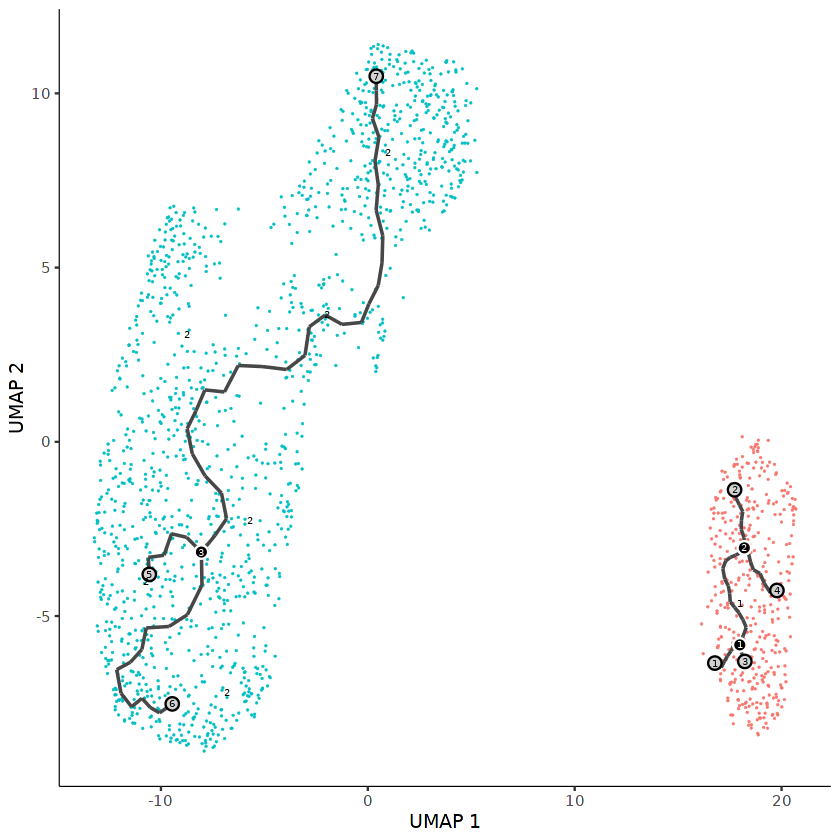

In [4]:
cds_cd8 = learn_graph(cds_cd8, learn_graph_control=list(minimal_branch_len=15, rann.k=50, ncenter=150), 
                      use_partition=T, close_loop=T, verbose=F)
suppressWarnings(plot_cells(cds_cd8, color_cells_by = "partition"))

### 1.3 Order Cells Along the Pseudotime
To assign pseudotime values to each cell we need to define the root cells, or in other words we have to define where the pseudotime trajectory starts. Afterwards, <code>order_cells</code> function will order cells along the previously inferred trajectory.
<div class="alert alert-block alert-warning">
&#128308;<b> Warning:</b> Using <b>order_cells</b> function without providing root cells (or root nodes) will try to open an interactive session, so that you can choose the root cell interactively on the UMAP. However, the native jupyter notebook does not support interactive sessions and will give an error.</br>
&#128994; In order to have use interactive session, please use softwares such as Rstudio or vscode!
</div>
&#8505;<b> Info:</b> We have previously defined root cells in an interactive session (in Rstudio) and provided them to the function. 

In [5]:
cds_cd8 = order_cells(cds_cd8, root_cells=c("A17_10","E19_8"))

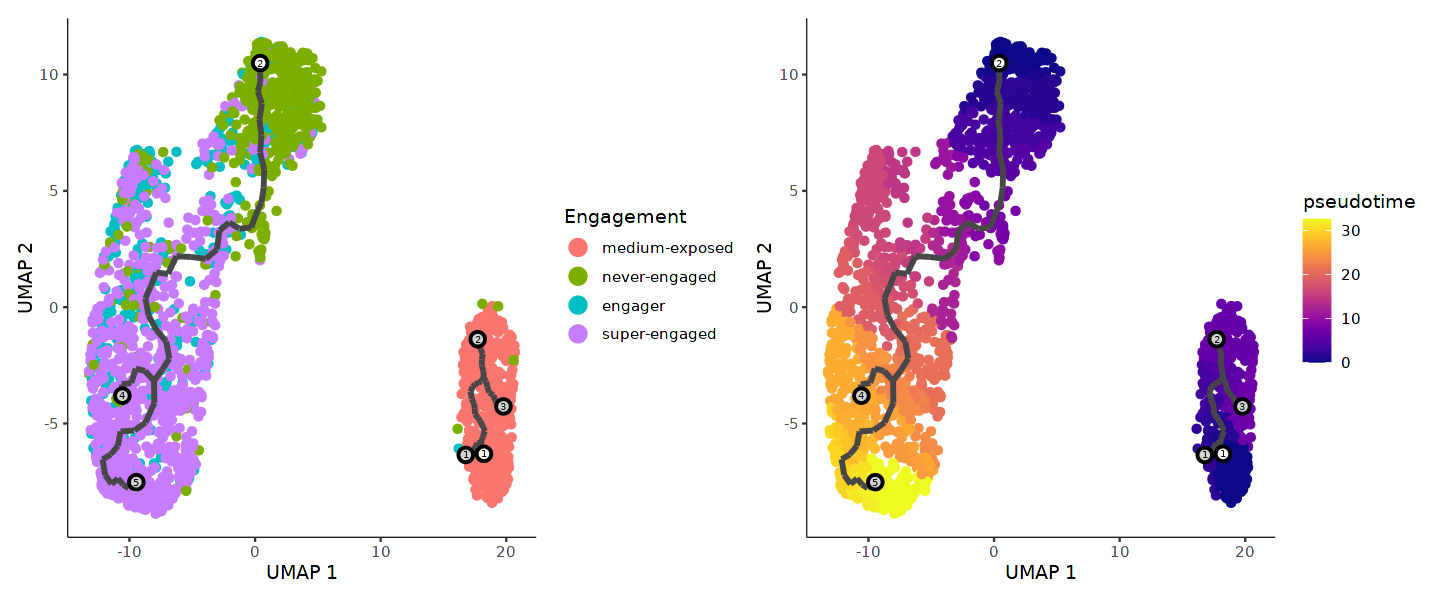

In [6]:
options(repr.plot.width=12, repr.plot.height=5)
suppressWarnings(plot_cells(cds_cd8, cell_size=1.5, label_cell_groups=F, labels_per_group=F, 
                            color_cells_by="Engagement", label_branch_points=F, trajectory_graph_segment_size=1.25)) +
plot_cells(cds_cd8, cell_size=1.5, label_cell_groups=F, labels_per_group=F, 
           color_cells_by="pseudotime", label_branch_points=F, trajectory_graph_segment_size=1.25)

### 1.4 Concatenate Pseudotime Partitions
From the above pseudotime trajectory, it is apparent that we have two separate partitions (two separate trajectories). As biologically, medium exposed TEGs (without being co-cultured with tumor organoids) are placed before the exposure to cancer cells, we will concatenate two trajectories together by adding maximum pseudotime value of medium-exposed cells to other cell's pseudotime values.</br>

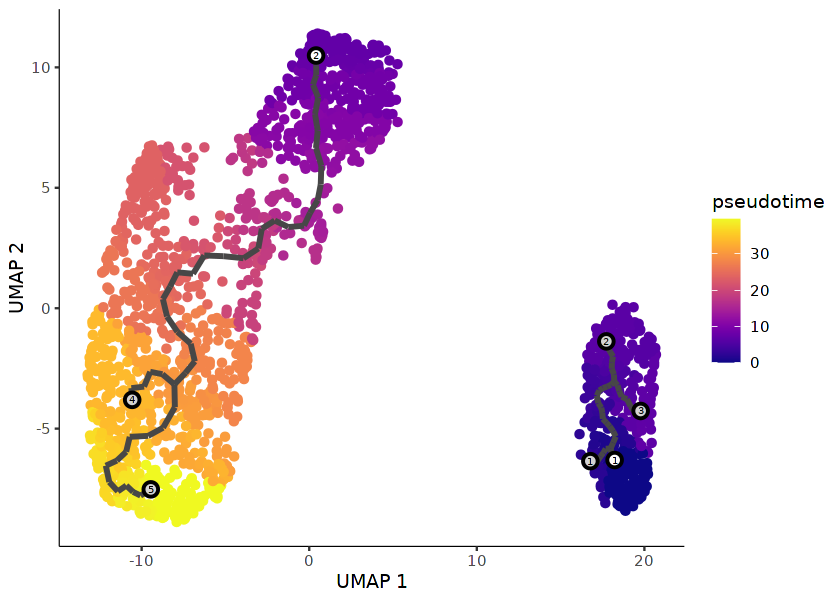

In [7]:
temp = grep(names(which.max(table(cds_cd8@clusters$UMAP$partitions, cds_cd8$Engagement == "medium-exposed")[,"TRUE"])), cds_cd8@clusters$UMAP$partitions)
max_time = max(cds_cd8@principal_graph_aux$UMAP$pseudotime[temp])
temp = grep(names(which.min(table(cds_cd8@clusters$UMAP$partitions, cds_cd8$Engagement == "medium-exposed")[,"TRUE"])), cds_cd8@clusters$UMAP$partitions)
cds_cd8@principal_graph_aux$UMAP$pseudotime[temp]=cds_cd8@principal_graph_aux$UMAP$pseudotime[temp] + max_time

# Plot Cells
options(repr.plot.width=7, repr.plot.height=5)
plot_cells(cds_cd8, cell_size=1.5, label_cell_groups=F, labels_per_group=F, color_cells_by="pseudotime", label_branch_points=F, trajectory_graph_segment_size=1.25)

### 1.5 Add Inferred Pseudotime Values to Seurat Object
To be able to use the pseudotime values calculated in the downstream analysis we add them to the original Seurat object as a metadata.

In [8]:
cd8_mnn$Pseudotime = cds_cd8@principal_graph_aux$UMAP$pseudotime

### 1.6 Identify Dynamic Gene Along the Pseudotime Trajectory
Using <code>graph_test</code> function from <code>monocle3</code> package we will identify significantly dynamic genes along the pseudotime trajectory.</br>
In addition, we will take into account only the genes which are expressed in more than 100 cells to have the most frequently expressed and informative genes for the downstream analysis.

In [9]:
cds_pr_test_res = graph_test(cds_cd8, neighbor_graph = "principal_graph", cores = 4, k = 10)
pr_deg_ids = row.names(subset(cds_pr_test_res, q_value < 1e-20))

# Keep only those genes who are expressed in more than 100 single-cells
tbl = GetAssayData(cd8_mnn, slot = "data")
tbl = tbl[pr_deg_ids,]
cell_gene = rowSums(tbl > 0)
tbl = tbl[which(cell_gene > 100),]
dynamicGenes_cd8 = rownames(tbl)

  |=======================================================| 100%, Elapsed 03:42


### 1.7 Save Dynamic Genes & Objects for Downstream Analysis
We will save results of the analysis workflow for the next part of analysis pipeline (clustering and visualiztion of dynamic genes from all TEG subsets.)

In [10]:
saveRDS(cd8_mnn, "CD8_MNN_Seurat.rds")
saveRDS(dynamicGenes_cd8, "CD8_Dynamic_Genes.rds")

</br>

## 2. Pseudotime Trajectory Inference of CD4+ IL17RB- TEGs

&#10071; Before you start, make sure that you have the data in the current working directory.
### 2.1 Read Seurat Object and Convert to a SingleCellExperiment Object
<code>monocle3</code> package that we will use for the pseudotime analysis uses the SingleCellExperiment data structure, so we first need to convert the Seurat object to a SingleCellExperiment object.

In [11]:
cd4_1_mnn = readRDS("CD4_IL17RBNeg_MNN_Seurat.rds")
cds_cd4_1 = suppressWarnings(as.cell_data_set(cd4_1_mnn))
rowData(cds_cd4_1)$gene_name = rownames(cds_cd4_1)
rowData(cds_cd4_1)$gene_short_name = rowData(cds_cd4_1)$gene_name
cds_cd4_1 = estimate_size_factors(cds_cd4_1)

### 2.2 Infer Pseudotime Trajecotry (Using monocle3)
First we will cluster and partition cells and then using <code>learn_graph</code> function we will infer the pseudotime trajectory of CD4+ IL17RB- TEGs. 

In [12]:
cds_cd4_1 = cluster_cells(cds_cd4_1, k=40, num_iter=10, partition_qval=0.75, resolution=0.02)

  |======================================================================| 100%


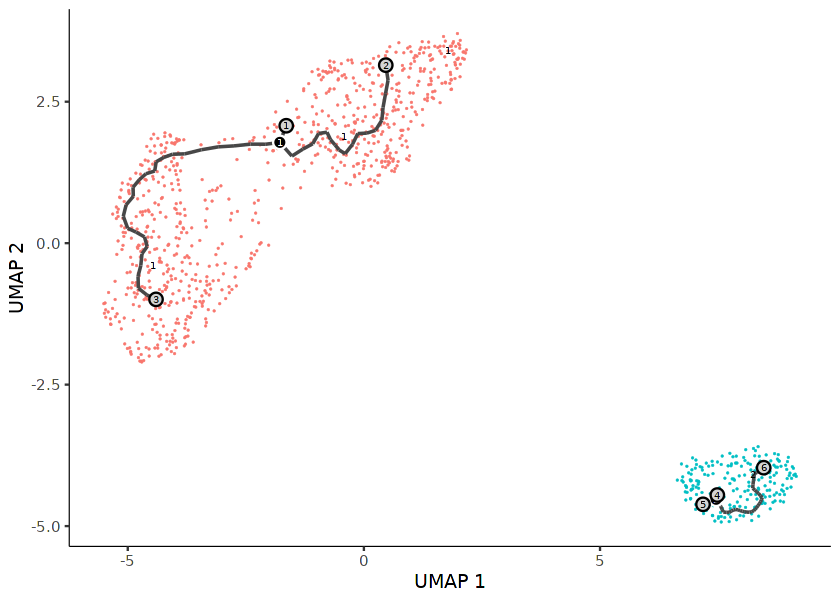

In [13]:
cds_cd4_1 = learn_graph(cds_cd4_1, learn_graph_control=list(minimal_branch_len=20, rann.k=25, ncenter=150), 
                        use_partition=T, close_loop=T, verbose=F)
plot_cells(cds_cd4_1, color_cells_by = "partition")

### 2.3 Order Cells Along the Pseudotime
To assign pseudotime values to each cell we need to define the root cells, or in other words we have to define where the pseudotime trajectory starts. Afterwards, <code>order_cells</code> function will order cells along the previously inferred trajectory.
<div class="alert alert-block alert-warning">
&#128308;<b> Warning:</b> Using <b>order_cells</b> function without providing root cells (or root nodes) will try to open an interactive session, so that you can choose the root cell interactively on the UMAP. However, the native jupyter notebook does not support interactive sessions and will give an error.</br>
&#128994; In order to have use interactive session, please use softwares such as Rstudio or vscode!
</div>
&#8505;<b> Info:</b> We have previously defined root cells in an interactive session (in Rstudio) and provided them to the function. 

In [14]:
cds_cd4_1 = order_cells(cds_cd4_1, root_cells = c("M17_5","L15_8"))

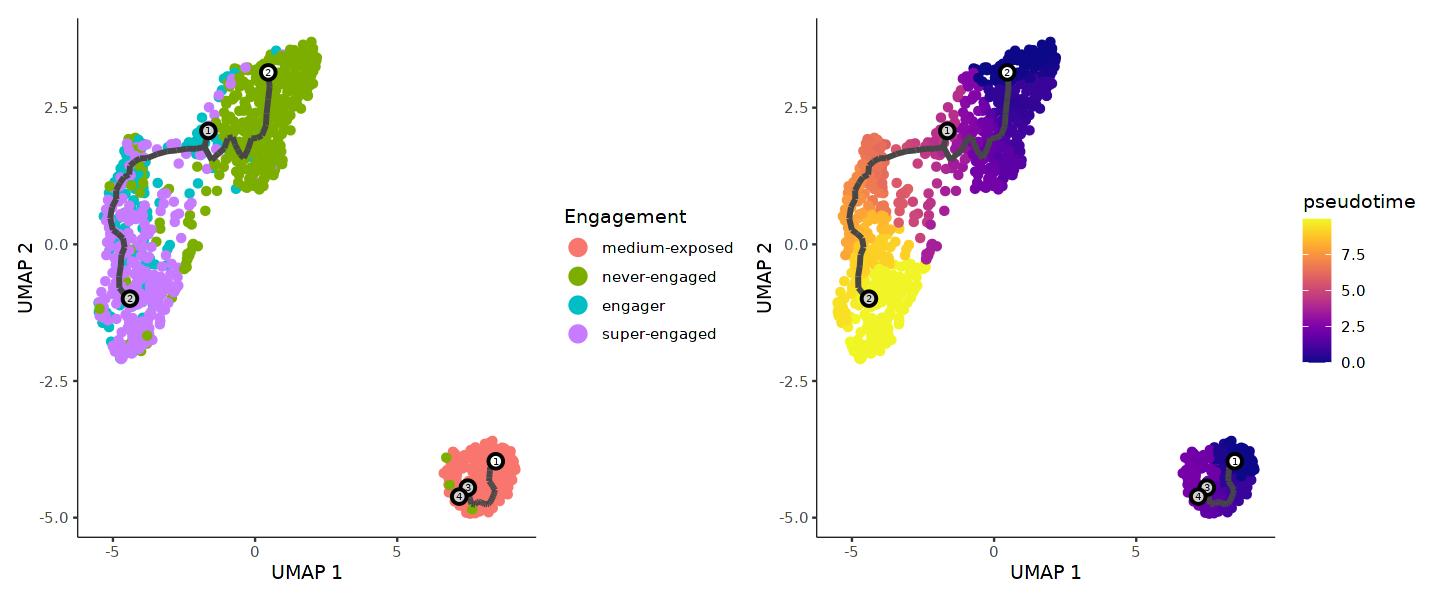

In [15]:
options(repr.plot.width=12, repr.plot.height=5)
plot_cells(cds_cd4_1, cell_size=1.5, label_cell_groups=F, labels_per_group=F, color_cells_by="Engagement", label_branch_points=F, trajectory_graph_segment_size=1.25) + 
plot_cells(cds_cd4_1, cell_size=1.5, label_cell_groups=F, labels_per_group=F, color_cells_by="pseudotime", label_branch_points=F, trajectory_graph_segment_size=1.25)

### 2.4 Concatenate Pseudotime Partitions
From the above pseudotime trajectory, it is apparent that we have two separate partitions (two separate trajectories). As biologically, medium exposed TEGs (without being co-cultured with tumor organoids) are placed before the exposure to cancer cells, we will concatenate two trajectories together by adding maximum pseudotime value of medium-exposed cells to other cell's pseudotime values.</br>

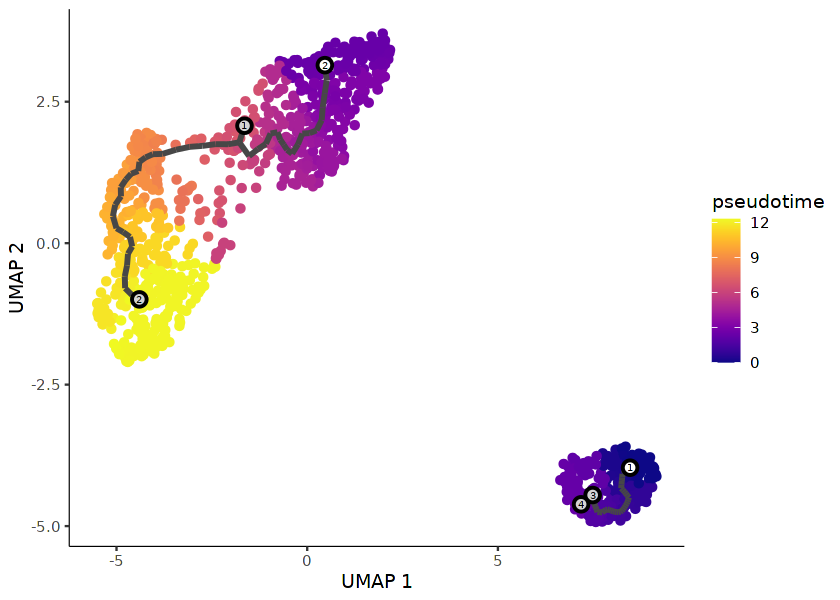

In [16]:
temp = grep(names(which.max(table(cds_cd4_1@clusters$UMAP$partitions, cds_cd4_1$Engagement == "medium-exposed")[,"TRUE"])), cds_cd4_1@clusters$UMAP$partitions)
max_time = max(cds_cd4_1@principal_graph_aux$UMAP$pseudotime[temp])
temp = grep(names(which.min(table(cds_cd4_1@clusters$UMAP$partitions, cds_cd4_1$Engagement == "medium-exposed")[,"TRUE"])), cds_cd4_1@clusters$UMAP$partitions)
cds_cd4_1@principal_graph_aux$UMAP$pseudotime[temp] = cds_cd4_1@principal_graph_aux$UMAP$pseudotime[temp] + max_time

# Plot Cells
options(repr.plot.width=7, repr.plot.height=5)
plot_cells(cds_cd4_1, cell_size=1.5, label_cell_groups=F, labels_per_group=F, color_cells_by="pseudotime", label_branch_points=F, trajectory_graph_segment_size=1.25) 

### 2.5 Add Inferred Pseudotime Values to Seurat Object
To be able to use the pseudotime values calculated in the downstream analysis we add them to the original Seurat object as a metadata.

In [17]:
cd4_1_mnn$Pseudotime = cds_cd4_1@principal_graph_aux$UMAP$pseudotime

### 2.6 Identify Dynamic Gene Along the Pseudotime Trajectory
Using <code>graph_test</code> function from <code>monocle3</code> package we will identify significantly dynamic genes along the pseudotime trajectory.</br>
In addition, we will take into account only the genes which are expressed in more than 100 cells to have the most frequently expressed and informative genes for the downstream analysis.

In [18]:
cds_pr_test_res = graph_test(cds_cd4_1, neighbor_graph = "principal_graph", cores = 4, k = 10)
pr_deg_ids = row.names(subset(cds_pr_test_res, q_value < 1e-20))

# Keep only those genes who are expressed in more than 100 single-cells
tbl = GetAssayData(cd4_1_mnn, slot = "data")
tbl = tbl[pr_deg_ids,]
cell_gene = rowSums(tbl > 0)
tbl = tbl[which(cell_gene > 100),]
dynamicGenes_cd4_1 = rownames(tbl)

  |=======================================================| 100%, Elapsed 02:13


### 2.7 Save Dynamic Genes & Objects for Downstream Analysis
We will save results of the analysis workflow for the next part of analysis pipeline (clustering and visualiztion of dynamic genes from all TEG subsets.)

In [19]:
saveRDS(cd4_1_mnn, "CD4_IL17RBNeg_MNN_Seurat.rds")
saveRDS(dynamicGenes_cd4_1, "CD4_IL17RBNeg_Dynamic_Genes.rds")

</br>

## 3. Pseudotime Trajectory Inference of CD4+ IL17RB+ TEGs

&#10071; Before you start, make sure that you have the data in the current working directory.
### 3.1 Read Seurat Object and Convert to a SingleCellExperiment Object
<code>monocle3</code> package that we will use for the pseudotime analysis uses the SingleCellExperiment data structure, so we first need to convert the Seurat object to a SingleCellExperiment object.

In [20]:
cd4_2_mnn = readRDS("CD4_IL17RBPos_MNN_Seurat.rds")
cds_cd4_2 = suppressWarnings(as.cell_data_set(cd4_2_mnn))
rowData(cds_cd4_2)$gene_name = rownames(cds_cd4_2)
rowData(cds_cd4_2)$gene_short_name = rowData(cds_cd4_2)$gene_name
cds_cd4_2 = estimate_size_factors(cds_cd4_2)

### 3.2 Infer Pseudotime Trajecotry (Using monocle3)
First we will cluster and partition cells and then using <code>learn_graph</code> function we will infer the pseudotime trajectory of CD4+ IL17RB+ TEGs. 

In [21]:
cds_cd4_2 = cluster_cells(cds_cd4_2, k=40, num_iter=10, partition_qval=0.75, resolution=0.02)

  |======================================================================| 100%


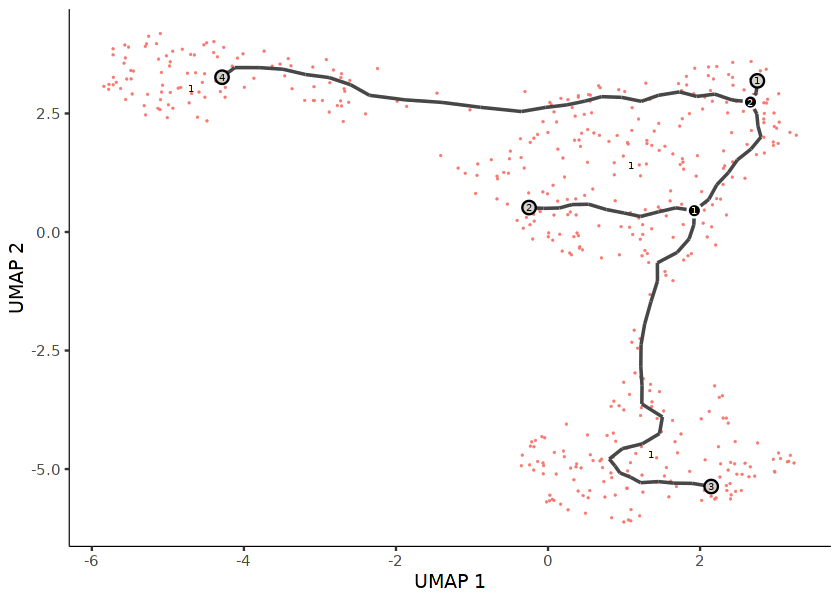

In [22]:
cds_cd4_2 = learn_graph(cds_cd4_2, learn_graph_control=list(minimal_branch_len=10, rann.k=20, ncenter=150),
                        use_partition=T, close_loop=T)
plot_cells(cds_cd4_2, color_cells_by = "partition")

### 3.3 Order Cells Along the Pseudotime
To assign pseudotime values to each cell we need to define the root cells, or in other words we have to define where the pseudotime trajectory starts. Afterwards, <code>order_cells</code> function will order cells along the previously inferred trajectory.
<div class="alert alert-block alert-warning">
&#128308;<b> Warning:</b> Using <b>order_cells</b> function without providing root cells (or root nodes) will try to open an interactive session, so that you can choose the root cell interactively on the UMAP. However, the native jupyter notebook does not support interactive sessions and will give an error.</br>
&#128994; In order to have use interactive session, please use softwares such as Rstudio or vscode!
</div>
&#8505;<b> Info:</b> We have previously defined root cells in an interactive session (in Rstudio) and provided them to the function. 

In [23]:
cds_cd4_2 = order_cells(cds_cd4_2, root_cells = "F8_5")

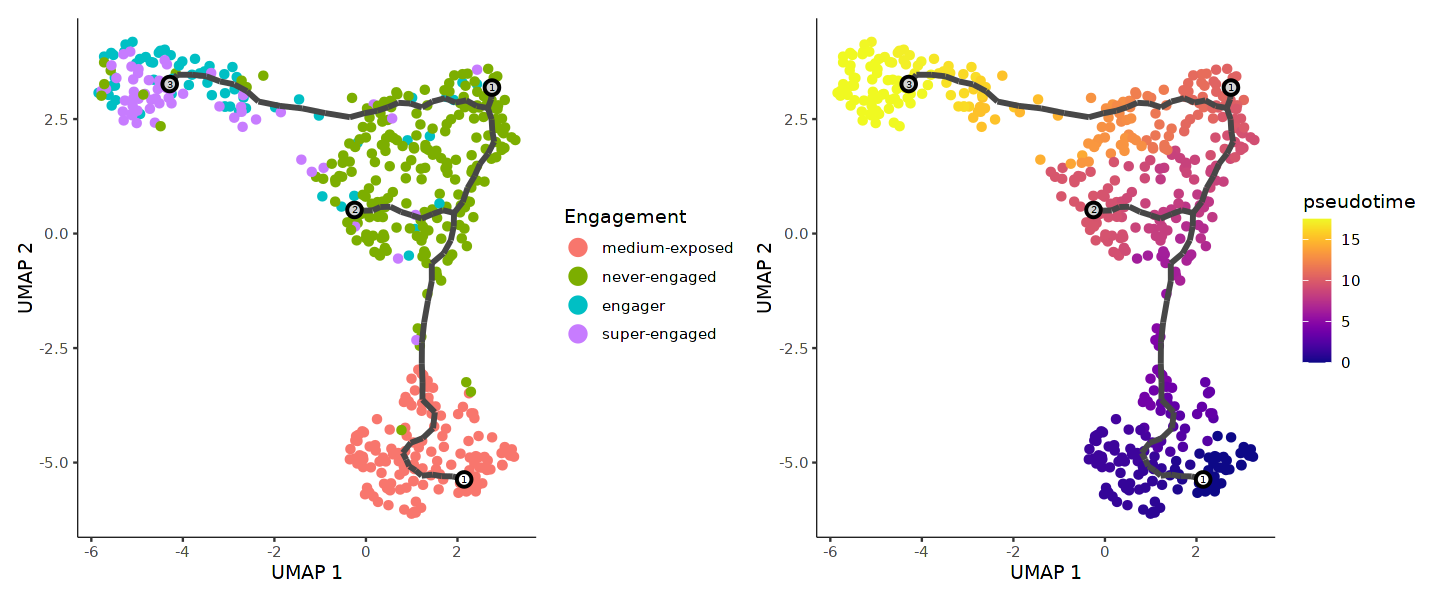

In [24]:
options(repr.plot.width=12, repr.plot.height=5)
plot_cells(cds_cd4_2, cell_size=1.5, label_cell_groups=F, labels_per_group=F, color_cells_by="Engagement", label_branch_points=F, trajectory_graph_segment_size=1.25) + 
plot_cells(cds_cd4_2, cell_size=1.5, label_cell_groups=F, labels_per_group=F, color_cells_by="pseudotime", label_branch_points=F, trajectory_graph_segment_size=1.25)

</br>
<div class="alert alert-info">
<b>Note:</b> Since we only got 1 partition for CD4+ IL17RB+ TEGs, there is no need to concatenate two separate partition-specific pseudotime trajectories.</br></div>

### 3.4 Add Inferred Pseudotime Values to Seurat Object
To be able to use the pseudotime values calculated in the downstream analysis we add them to the original Seurat object as a metadata.

In [25]:
cd4_2_mnn$Pseudotime = cds_cd4_2@principal_graph_aux$UMAP$pseudotime

### 3.5 Identify Dynamic Gene Along the Pseudotime Trajectory
Using <code>graph_test</code> function from <code>monocle3</code> package we will identify significantly dynamic genes along the pseudotime trajectory.</br>
In addition, we will take into account only the genes which are expressed in more than 25 cells to have the most frequently expressed and informative genes for the downstream analysis.

In [26]:
cds_pr_test_res = graph_test(cds_cd4_2, neighbor_graph = "principal_graph", cores = 4, k = 10)
pr_deg_ids = row.names(subset(cds_pr_test_res, q_value < 1e-20))

# Keep only those genes who are expressed in more than 25 single-cells
tbl = GetAssayData(cd4_2_mnn, slot = "data")
tbl = tbl[pr_deg_ids,]
cell_gene = rowSums(tbl > 0)
tbl = tbl[which(cell_gene > 25),]
dynamicGenes_cd4_2 = rownames(tbl)

  |=======================================================| 100%, Elapsed 01:11


### 3.6 Save Dynamic Genes & Objects for Downstream Analysis
We will save results of the analysis workflow for the next part of analysis pipeline (clustering and visualiztion of dynamic genes from all TEG subsets.)

In [27]:
saveRDS(cd4_2_mnn, "CD4_IL17RBPos_MNN_Seurat.rds")
saveRDS(dynamicGenes_cd4_2, "CD4_IL17RBPos_Dynamic_Genes.rds")

In [28]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] monocle3_0.2.3.0            SingleCellExperiment_1.12.0
 [3] SummarizedExperiment_1.20.0 GenomicRanges_1.42.0       
 [5] GenomeInfoDb_1.26.2         IRanges_2.24.1             
 [7] S4Vectors_0.28.1            MatrixGenerics_1